In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt  
import math
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from evaluate import evaluate_hw1

%matplotlib inline
%load_ext autoreload
%autoreload 2

Functions

In [2]:
def softmax(X):
    e_x = torch.exp(X)
    results = e_x / (e_x.sum(axis=1).view(-1,1))
    return results    

def tanh(t):
    return torch.div(torch.exp(t) - torch.exp(-t), torch.exp(t) + torch.exp(-t))

def tanhPrime(t):
    return 1 - t*t

class Neural_Network:
    def __init__(self, input_size=28*28, output_size=10, hidden_size=50):
        # parameters
        self.inputSize = input_size 
        self.outputSize = output_size
        self.hiddenSize = hidden_size
        
        # weights
        self.W1 = (torch.randn(self.inputSize, self.hiddenSize)/10).float()
        self.b1 = (torch.zeros(self.hiddenSize)).float()
        
        self.W2 = (torch.randn(self.hiddenSize, self.outputSize)).float()
        self.b2 = (torch.zeros(self.outputSize)).float()
        
    def forward(self, X):
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.h = tanh(self.z1)
        self.z2 = torch.matmul(self.h, self.W2) + self.b2
        return softmax(self.z2)

    
    def backward(self, X, y, y_hat, lr=.1):

        y_len = y.shape[0]
        dl_dz2 = y_hat
        dl_dz2[range(y_len),y] -= 1 #cross entropy derivative 
        dl_dz2 = dl_dz2/y_len
        dl_dh = torch.matmul(dl_dz2.float(), torch.t(self.W2).float())
        dl_dz1 = dl_dh * tanhPrime(self.h)
        
        self.W1 -= lr*torch.matmul(torch.t(X), dl_dz1)
        self.b1 -= lr*torch.matmul(torch.t(dl_dz1), torch.ones(y_len))
        self.W2 -= lr*torch.matmul(torch.t(self.h).float(), dl_dz2.float())
        self.b2 -= lr*torch.matmul(torch.t(dl_dz2).float(), torch.ones(y_len).float())
    
        
    def train(self, X, y):
        o = self.forward(X)
        self.backward(X, y, o, lr=0.01)
        
def score_function(out , trues):
    out = torch.argmax(out, dim=1)
    trues = trues.view((-1))
    test_correct = out.eq(trues).sum().item()
    return test_correct

def cross(out, y):
    y_len= len(y)
    log_like = -torch.log(out[range(y_len),y])
    loss = torch.sum(log_like)
    return (loss)

preprocessing

In [13]:
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transform,
                            download=True,
                           )
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transform,
                          )
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                           batch_size=batch_size, 
#                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=len(test_dataset),
                                          shuffle=False)

Train

In [15]:
num_epochs = 10
NN = Neural_Network()
train_list = []
test_list = []
for epoch in range(num_epochs):
    total_loss_train = 0
    n_sampels_train = 0
    n_correct_train = 0
    for i,(x, y) in enumerate(train_loader):
        x = x.view(-1,28*28)
        x = x.float()
        NN.train(x, y)
        out = NN.forward(x)
        total_loss_train += cross(out, y).item()
        n_sampels_train += len(y)
        n_correct_train += score_function(out , y)
    ACC_train = n_correct_train/n_sampels_train*100
    train_list.append(ACC_train)
    total_loss_test = 0
    n_sampels_test = 0
    n_correct_test = 0
    for i,(x, y) in enumerate(test_loader):
        x = x.view(-1,28*28)
        x = x.float()
        y = y.view(-1,1)
        out = NN.forward(x)
        total_loss_test += cross(out, y).item()
        n_sampels_test += len(y)
        n_correct_test += score_function(out , y)
    ACC_test = n_correct_test/n_sampels_test*100
    print("Epoch=", epoch+1, "| Loss=", "{:.4f}".format(total_loss_train/n_sampels_train), "| Train ACC=", "{:.2f}".format(ACC_train),"%",  "| Test ACC=", "{:.2f}".format(ACC_test),"%")
    test_list.append(ACC_test)

Epoch= 1 | Loss= 1.2635 | Train ACC= 71.51 % | Test ACC= 82.97 %
Epoch= 2 | Loss= 0.5533 | Train ACC= 85.33 % | Test ACC= 86.73 %
Epoch= 3 | Loss= 0.4443 | Train ACC= 88.03 % | Test ACC= 88.24 %
Epoch= 4 | Loss= 0.3868 | Train ACC= 89.48 % | Test ACC= 89.28 %


KeyboardInterrupt: 

In [ ]:
torch.save(NN, "model.pkl")

Text(0, 0.5, 'ACC')

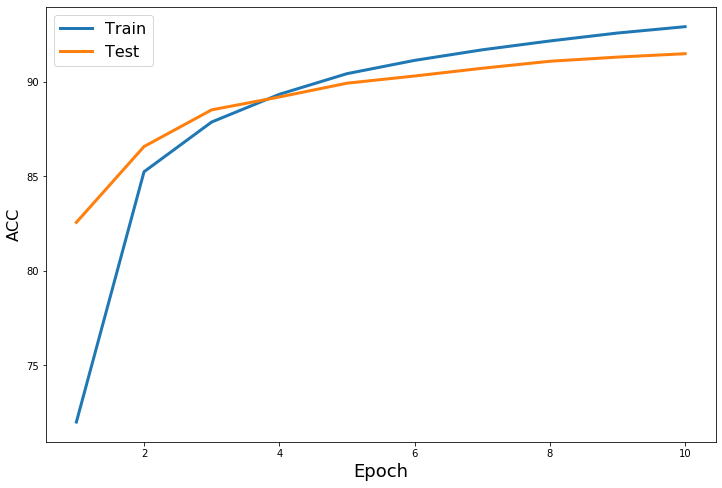

In [7]:
num_Epochs = list(range(1,num_epochs+1))
plt.figure(figsize=(12,8))
plt.plot(num_Epochs, train_list, label="Train", linewidth=3)
plt.plot(num_Epochs, test_list, label="Test", linewidth=3)

plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('ACC', fontsize=16)

In [5]:
evaluate_hw1()

ACC in Test =  90.86 %


Test

In [6]:
NN = torch.load("model.pkl")
n_sampels = 0
n_correct = 0
total_loss = 0
for i,(x, y) in enumerate(test_loader):
    x = x.view(-1,28*28)
    x = x.float()
    y = y.view(-1,1)
    out = NN.forward(x)
    total_loss += cross(out, y).item()
    n_sampels += len(y)
    n_correct += score_function(out , y)
print("ACC in Test = ", "{:.2f}".format(n_correct/n_sampels*100),"%")

ACC in Test =  90.86 %
